In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import os, os.path
from scipy import optimize, interpolate, signal
from scipy.fftpack import fft, fftfreq
import itertools

## 2theta-omega

C:\Users\Yoshimi\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


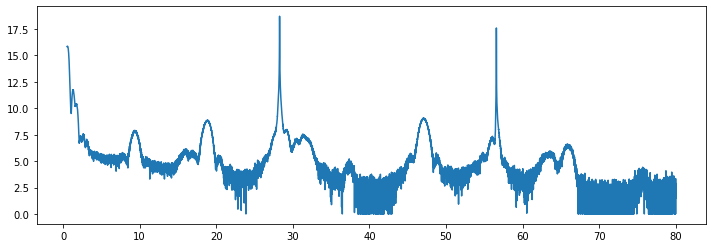

In [10]:
xrd_lambda = 1.540598

filepath = r"D:\GoogleDrive\Lab\Experiment\XRD\BST\#1-1356_CBST_BST\2tw.dat"
filedir = os.path.dirname(filepath)
filebasename = os.path.basename(filepath)
filename, fileext = os.path.splitext(filebasename)
                                     
df = pd.read_csv(filepath, skiprows = 2, delimiter = "\s")
df.columns = ["2theta", "int"]
df.to_csv(os.path.join(filedir, filename + ".csv"), index = False)

df["q"] = 4 * np.pi * np.sin(df["2theta"] * np.pi / 360)/ xrd_lambda
df["q_lnsp"] = np.linspace(np.min(df["q"]), np.max(df["q"]), np.size(df["q"]))
lar_intp = interpolate.interp1d(df["q"], df["int"])
df["int_log"] = np.log(lar_intp(df["q_lnsp"]) + 1)

plt.figure(figsize = (12, 4))
plt.plot(df["2theta"], df["int_log"])

C:\Users\Yoshimi\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


[10.15123339  0.01342027 -0.73890026]


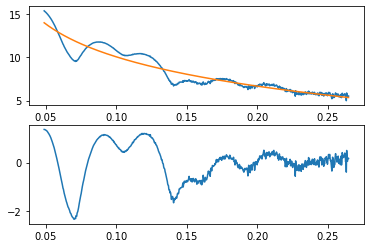

In [11]:
two_theta_min = 0.7
two_theta_max = 4
t_upperbound = 200 # nm

df_trim = df.loc[df.index[(df["2theta"] > two_theta_min) & (df["2theta"] < two_theta_max)].tolist()]

def xrd_ref_bg(q, a, b, c):
    return -a * np.log10((q - b)) + c

param_a = np.linspace(0.1, 500, 51)
param_b = np.linspace(-10, 0, 16)
param_c = np.linspace(-5,5,11)

for a, b, c in itertools.product(param_a, param_b, param_c):
    param_init = [a, b, c]
    try:
        param_opti, _ = optimize.curve_fit(xrd_ref_bg, df_trim["q_lnsp"].values, df_trim["int_log"].values, p0 = param_init)
        print(param_opti)
        df_trim["int_bg_log"] = xrd_ref_bg(df_trim.loc[:, "q_lnsp"], *param_opti)
        df_trim["int_osci"] = df_trim["int_log"] - df_trim["int_bg_log"]
        plt.subplot(2,1,1)
        plt.plot(df_trim["q_lnsp"], df_trim["int_log"])
        plt.plot(df_trim["q_lnsp"], df_trim["int_bg_log"])
        plt.subplot(2,1,2)
        plt.plot(df_trim["q_lnsp"], df_trim["int_osci"]) 
        break
    except (RuntimeError):
        pass

(-0.15161883832163725, 10.971442064920776)

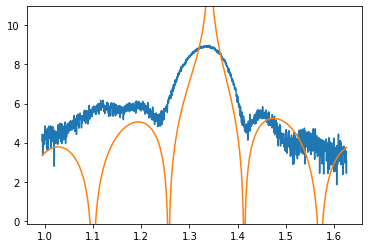

In [4]:
two_theta_min = 14
two_theta_max = 23
thick_init = 40 #nm

df_trim = df.loc[df.index[(df["2theta"] > two_theta_min) & (df["2theta"] < two_theta_max)].tolist()]

plt.plot(df_trim["q"], df_trim["int_log"])
#初期値推定
#2theta_omegaの最大値からd_initを推定
two_theta_peak = df_trim["2theta"].values[np.argmax(df_trim["int_log"])]
q_peak = df_trim["q"].values[np.argmax(df_trim["int_log"])]
d_init = 2 * np.pi / q_peak
M_init = thick_init / d_init

def laue_func(q, d, M, A):
    return np.log(np.sin(q * d * M / 2)**2) - np.log(np.sin(q * d / 2)**2) + A

param_init = [M_init, 10]
# param_opti, _ = optimize.curve_fit(lambda q, M, A: laue_func(q, d_init, M, A), df_trim["q_lnsp"].values, df_trim["int_log"].values, p0 = param_init)
# plt.plot(df_trim["q"], laue_func(df_trim["q"].values, d_init, *param_opti))
plt.plot(df_trim["q"], laue_func(df_trim["q"].values, d_init, M_init, 3))
plt.ylim(bottom = np.min(df_trim["int_log"]) - 2, top = np.max(df_trim["int_log"]) + 2)

period of q_oscillation = 0.072
thickness = 8.73 nm
ps = 237.3

period of q_oscillation = 0.043
thickness = 14.55 nm
ps = 177.4

period of q_oscillation = 0.024
thickness = 26.19 nm
ps = 76.2




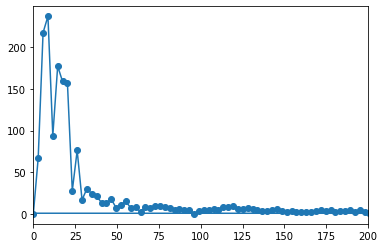

In [12]:
int_fft = fft(df_trim["int_osci"].values)
N = len(df_trim["int_osci"])
q_spacing = np.abs(df_trim["q_lnsp"].values[1] - df_trim["q_lnsp"].values[0])
df_trim["q_freq"] = fftfreq(N, q_spacing)

#ps = power spectrum
df_trim["int_ps"] = np.abs(int_fft)
#dq = period of oscillation 
#q_freq = inverse of dq
df_trim["q_period"] = 1 / df_trim["q_freq"]
df_trim["thickness"] = 2 * np.pi * df_trim["q_freq"] * 0.1

df_trim.to_csv(os.path.join(filedir, filename + "_fft.csv"), index = False)

plt.plot(df_trim["thickness"], df_trim["int_ps"], "o-")
plt.xlim(0, t_upperbound)

#### search preak ####
fft_peak = signal.argrelmax(df_trim["int_ps"].values)
fft_peak_value = df_trim["int_ps"].values[fft_peak]
q_osci = 1/df_trim["q_freq"].values[fft_peak]
thickness_nm = 2 * np.pi * 0.1 * df_trim["q_freq"].values[fft_peak]
fft_result = np.array([fft_peak_value, q_osci, thickness_nm])
fft_result = fft_result[:, fft_result[0,:].argsort()[::-1]]
fft_peak_value = fft_result[0]
q_osci = fft_result[1]
thickness_nm = fft_result[2]

#print(q_osci)
#print(thickness_nm)

for (i, x) in enumerate(fft_peak_value):
    if i == 0:
        fft_result = ""
    if(thickness_nm[i] > 0 and thickness_nm[i] < t_upperbound and x > fft_peak_value[0] * 0.2):
        fft_result += "period of q_oscillation = {:.3f}".format(q_osci[i])
        fft_result += "\nthickness = {:.2f} nm".format(thickness_nm[i])
        fft_result += "\nps = {0:.1f}".format(x)
        fft_result += "\n\n"
        
print(fft_result)
        

fft_result_path = os.path.join(filedir, filename + "_fft_summary.txt")     
with open(fft_result_path, mode='w') as f:
    f.write(fft_result)

## rocking

center: 8.702
FWHM: 0.164


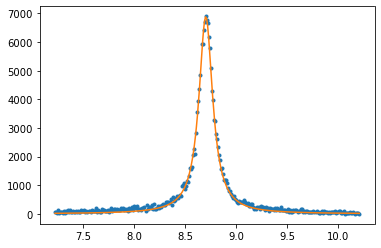

In [14]:
filepath = r"D:\GoogleDrive\Lab\Experiment\XRD\BST\#1-1356_CBST_BST\rock006.dat"

filedir = os.path.dirname(filepath)
filebasename = os.path.basename(filepath)
filename, fileext = os.path.splitext(filebasename)

df = pd.read_csv(filepath, skiprows = 2, delimiter = " ")
df.columns = ["omega", "int"]
plt.plot(df["omega"], df["int"], ".")

###############################################
def lor(x, a, b, c):
    return c / ((x - a) **2 + b)
###############################################

#初期値設定
int_max = np.max(df["int"].values)
omega_max = df["omega"].values[np.argmax(df["int"].values)]
a = omega_max
b = 1/400 #半値幅0.1くらい
c = int_max * b
#fitting
param_init = [a, b, c]
param_opti, _  = optimize.curve_fit(lor, df["omega"].values, df["int"].values, p0 = param_init, maxfev = 1000)
fit_result = "center: {0:.3f}\nFWHM: {1:.3f}".format(param_opti[0], 2 * np.sqrt(param_opti[1]))
print(fit_result)
plt.plot(df["omega"], lor(df["omega"], *param_opti))

#dfにフィッティング結果を詰める
df["d_omega"] = df["omega"] - param_opti[0]
df["lor_fit"] = lor(df["omega"], *param_opti)
# print(df)
df.to_csv(os.path.join(filedir, filename + ".csv"), index = False)

#フィッティングパラメータを出力
fit_result_path = os.path.join(filedir, filename + "_fit.txt")
with open(fit_result_path, mode='w') as f:
    f.write(fit_result)